In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product, combinations
from numba import jit, njit

## data load
http://www.kamishima.net/archive/freqpat.pdf

In [32]:
onigiri_data = pd.read_csv('onigiri.csv', sep=',')
onigiri_array = onigiri_data.values

In [33]:
onigiri_data

,a,b,c,d,e
0,0,1,1,1,0
1,1,1,0,0,0
2,1,0,0,1,1
3,0,1,1,1,0
4,0,1,0,1,0


In [34]:
## Define Class

In [35]:
class Rule:
    def __init__(self, ant, con):
        self.ant= ant
        self.con = con
        
    def print(self):
        print("Rule(%s, %s)" % (str(self.ant), str(self.con)))

In [36]:
r1 = Rule([1],[2,3])
r1.print()

Rule([1], [2, 3])


## 関数を定義

In [37]:
# return boolean 
def GTI(df, indexes): # Get True Indexes
    '''
    Input
        df: dataframe (row: transactions, col: items)
        index: column indexes num to be examined 
    Output
        list of boolen
    '''
    if type(indexes) == int:
        indexes = [indexes]
    elif type(indexes) == np.int64:
        indexes = [indexes]
        
    return df[:,indexes]==1

In [38]:
def support(array_2d,  indexes, m='num'):
    gti_b = GTI(array_2d, indexes)
    if gti_b.shape[1]==0:
        return 0
    b = np.all(gti_b, axis=1)
    if m =='num':
        return np.sum(b)
    elif m =='ratio':
        return np.sum(b)/len(b)
    elif m == 'bool':
        return b

In [39]:
def confidence(array_2d, X_indexes, Y_indexes):
    sup_X = support(array_2d, X_indexes)
    X_Y_indexes = np.hstack([X_indexes, Y_indexes])
    return support(array_2d, X_Y_indexes)/sup_X
    

In [40]:
def getF1(array_2D, minsup):
    '''
    Description
        Output frequent itemset from original tables (k=1)
    Input
        array_2D -> row: transactions, col: items
    Output
        frequent items' indexes: list
    '''
    return np.array([[col] for col in range(array_2D.shape[1]) if support(array_2D,col, m='ratio') >= minsup])

In [41]:
def getFkPlusOne(array_2D, indexes, minsup):
    '''
    Description
        Output frequent itemset from original tables (k=1)
    Input
        array_2D -> row: transactions, col: items
        indexes -> list of tuples [(),(),...()] 
    '''
    
    return np.array([col for col in indexes if support(array_2D,col, m='ratio') >= minsup])

In [42]:
def getCkPlusOne(prevCandidate, k):
    '''
    input
    prevCandidate: [(),(),...,()] # list of tuples
    k: length of next Candidate
    Output
      nextCandidate:[(),(),...,()] # list of tuples
     '''
    
    assert np.all(np.array([len(x) for x in prevCandidate])== k-1)
    assert k >1
    items = list(np.unique(np.array(prevCandidate).flatten())) 
    tmp_candidates = [x for x in combinations(items, k)]
    if k ==2:
        return np.array(tmp_candidates)
        
    candidates = [
        candidate for candidate in tmp_candidates
        if all(
            x in prevCandidate
            for x in combinations(candidate, k - 1))
    ]
       
    return np.array(candidates)

In [43]:
def isEmpty(F):
    if len(F) < 1:
        return True
    else:
        return False

In [44]:
def isCalcConfNeeded(array_prev_ant, array_ant, set_f):
    
        '''
        Input 
            array_prev_ant: array([1,2], [1,3], [2,3])
            array_ant: array([1],[2],[3])
            set_f: [1,2,3]
            
        Var
            array_prev_con: array([3],[2],[1])
            array_con: array([2,3,[1,3],[1,2])
        
        '''
        array_prev_con  = np.array([tuple(set_f - set(c))  for c in array_prev_ant])
        array_con  = np.array([tuple(set_f - set(c))  for c in array_ant])
        
        out = []
        
        for a,c in zip(array_ant, array_con):
            out_inner = []
            for i in range(len(c)):
                #array_ant_candidate = a
                cand = c[i]
                array_candidate_ant = np.append(a, cand)
                array_candidate_con = np.delete(c, i)
                
                res = np.any([set(array_candidate_ant) <= set(i)  for i in array_prev_ant])
                out_inner.append(res)
            if np.all(out_inner):
                out.append(True)
            else:
                out.append(False)
            
        return out

In [45]:
a = np.zeros(10)
b = np.ones(10)

abb = np.vstack((a,b,b))
abba = np.vstack((abb,a))
print(abba)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [46]:
def frequent(db, minsup):
    
    #initialize table
    F_table = np.zeros(db.shape[1])
    
    k = 1
    F_list = []
    F_now = getF1(db, minsup)
    F_list.append(F_now)
    while(True):

        C_next = getCkPlusOne(F_now, k+1)

        F_next = getFkPlusOne(db, C_next, minsup)
        if isEmpty(F_next):
            break
        k += 1
        F_now = F_next
        F_list.append(F_now)
        
    return F_list

In [189]:
_F_list = frequent(onigiri_array, 0.4)
print(_F_list)

[array([[0],
       [1],
       [2],
       [3]]), array([[1, 2],
       [1, 3],
       [2, 3]]), array([[1, 2, 3]])]


In [201]:
np.array(_F_list).flatten()

array([array([[0],
       [1],
       [2],
       [3]]),
       array([[1, 2],
       [1, 3],
       [2, 3]]), array([[1, 2, 3]])], dtype=object)

In [180]:
tmp = np.array([])
tmptmp = np.zeros((1,10))
tmptmp[:,[1,2] ] =1
print(tmptmp)
np.vstack((tmp,tmptmp))

[[0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]]


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [155]:
'''
F_list =

    [array([[0],[1],[2],[3]]),          # k=1
      array([[1, 2],[1, 3],[2, 3]]),    # k=2
      array([[1, 2, 3]])],                     # k=3
      ...
      ]
'''
    
def find_rules(db, F_list, minconf) :
    conf_list = []
    for F in F_list: # F_listの中の特定のkに対するfrequent items
        k = len(F[0])
        if k == 1:
            conf_list.append([None])
            pass
        elif k == 2:
            conf_list_k = []
            for f_2 in F:
                A = f_2[0]
                B = f_2[1]
                conf_AB = confidence(db, A, B)
                if conf_AB >= minconf:
                    #conf_list_k.append((np.array([A]),np.array([B])))
                    conf_list_k.append(Rule([A],[B]))
                conf_BA = confidence(db, B, A)
                if conf_BA >= minconf:
                    #conf_list_k.append((np.array([B]),np.array([A])))
                    conf_list_k.append(Rule([B],[A]))

            conf_list.append(conf_list_k)
        
        elif k >= 3:
            conf_list_k = []
            for f_k in F:    # 特定のkに対する一つ一つのfrequent item
               
                
                '''example
                k=3
                
                j=1
                f_k: [1,2,3]
                conf: ([1,2],[3]), ([1,3],[2]),([2,3],[1]) # j = 1
                f_kからj=1個consequentを作りだしてconfidenceを求める
                confidenceがminconf以上のものをconf_listに格納
                格納するものを
                ([1,2],[3]),([2,3],[1])とする(※とする)。　([1,3],[2])はminconf未満
                
                j = 2
                f_k: [1,2,3]
                conf: ([1],[2,3]),([2],[1,3]),([3],[1,2])
                リストアップしたconfの全てに対してconfidenceを計算すると時間がかかるので、
                効率的に解く。
                
                例えば([1],[2,3])のconfidenceを計算する必要があるのか？については
                consequentから一つをantecedentに戻したもの全てが※に含まれる必要がある
                
                [1],[2,3]からは
                [1,2],[3]　および [1,3],[2]が得られる。conf_listに格納した値は
                [1,2],[3] および　[2,3],[1]　であるので条件を満たさない
                故に[1],[2,3]はconfidenceを計算する必要がない。
                
                [2],[1,3]からは
                [1,2],[3]　および [2,3],[1]が得られる。conf_listに格納した値は
                [1,2],[3] および　[2,3],[1]　であるので条件を満たす
                故に[2],[1,3]はconfidenceを上回る可能性があるので計算する必要がある。
                
                上記の探索は結局 対象としている相関ルールのantecedentが前回の※の全ての
                antecedentに含まれていることに帰着できる。
                
                '''
                
                set_all = set(f_k)
                j= 1 # k個のantecedentからj個をconsequentに移動させてconfidenceを算出する
                
                # 新しい相関ルール候補の作成
                array_antecedent = np.array(list(combinations(f_k, k-1 )))
                array_consequent = np.array([tuple(set_all - set(c))  for c in array_antecedent])
                conf = np.array([confidence(db, ant, con) for ant, con in zip(array_antecedent, array_consequent)])
                
                isHigher = conf >= minconf
                if sum(isHigher) > 0:
                    array_antecedent_filtered_by_conf = array_antecedent[isHigher]
                    array_consequent_filtered_by_conf = array_consequent[isHigher]
                    
                    conf_list_k.append([Rule(a,c) for a,c in zip(array_antecedent_filtered_by_conf, array_consequent_filtered_by_conf)])
             
               
               
                    while(j < k-1):
                        array_antecedent_new = np.array(list(combinations(f_k, k-(j+1) )))
                        # filter antecedent by previous conf
                        
                        _res = isCalcConfNeeded(array_antecedent_filtered_by_conf, array_antecedent_new, set_all)
                        
                        array_antecedent_filtered_by_prev = array_antecedent_new[_res]
                        array_consequent_filtered_by_prev = np.array([tuple(set_all - set(c))  for c in array_antecedent_filtered_by_prev])
                        conf = np.array([confidence(db, ant, con) for ant, con in zip(array_antecedent_filtered_by_prev, 
                                                                                                                                  array_consequent_filtered_by_prev)])
                        isHigher = conf >= minconf
                        if sum(isHigher) > 0:
                            array_antecedent_filtered_by_prev_and_conf = array_antecedent_filtered_by_prev[isHigher]
                            array_consequent_filtered_by_prev_and_conf = array_consequent_filtered_by_prev[isHigher]
                            
                            conf_list_k.append([Rule(a,c) for a,c in zip(array_antecedent_filtered_by_prev_and_conf, 
                                                                                                 array_consequent_filtered_by_prev_and_conf)])
                        
                        j += 1
            
            conf_list.append(conf_list_k)
    
    return conf_list
                

In [156]:
find_rules(onigiri_array, _F_list, 0.7)

[[None],
 [[<__main__.Rule at 0x7f09af13d3c8>, <__main__.Rule at 0x7f09a70ac898>],

## extraction of Frequent Items

- k =1
- データベースを数え上げて$F_1$を生成
  - ループ先頭
  - $F_k$から$C_{k+1}$を生成
  - $C_{k+1}$中の集合が実際に頻出かどうかを、データベースを数え上げて $F_{k+1}$を生成
  - $F_{k+1}$が空ならばループを終了
  - $k= k+1;$ ループ先頭に戻る
- 出力: $F1, F2, ..., F_{k+1}$

In [ ]:
db = store_array
minsum = 0.4
k = 1
F_list = []
F_now = getF1(store_array, minsum)
F_list.append(F_now)
while(True):
    print(k)
    print("F_now")
    print(F_now)
    print("calc C_k+1: k is set to %d" %  (k+1))
    C_next = getCkPlusOne(F_now, k+1)
    print("C_next")
    print(C_next)
    F_next = getFkPlusOne(store_array, C_next, minsum)
    if isEmpty(F_next):
        break
    k += 1
    F_now = F_next
    F_list.append(F_now)
    
del k

Frequent itemの格納リスト(F_list)
リストの中に、k個の頻出アイテムリストが入っている（リストのリスト）

**k=1が0番目のリストに入っているためインデックスの時は注意**

各リストの中は2次元のnp.ndarray形式で入っている。
2D配列中の値はデータ中の列インデックス番号。
k=1のときは一つの列に対するfrequent item。
k=2のときは二つの列の組み合わせに対するfrequent item。
frequent itemは複数あるので2次元の配列にしている。


例

In [XX]: F_list

Out[XX]:  [
                array([[0],[1],[2],[3]]),  # k =1
                
                array([[1,2], [1,3], [2,3]]),  # k = 2
                
                array([[1,2,3]]),　# k = 3
                
                ...
                
                ]
                

## 相関ルールの抽出

### 相関ルールのフォーマット

- conf_list: k個の相関ルールを格納するリスト
  - 0個めのインデックスにk=1がくるため、インデックスに注意

- **k=1のルールはない（「AならばB」のように最低2つのインデックスを使うので）**
  - ダミーとしてNoneを格納する
  
 conf_list の各要素の説明、
 [(array([1,2]), array([3])), ...]


- list(tuple(array, array)))の形
- tuple中の2つのarrayがantecedentとconsequent
- それをtupleでパッケージングしている。
- さらにそれが複数ありリストで格納している
 
 


In [144]:
conf_list = []
minconf = 0.7


'''
F_list =

    [array([[0],[1],[2],[3]]),          # k=1
      array([[1, 2],[1, 3],[2, 3]]),    # k=2
      array([[1, 2, 3]])],                     # k=3
      ...
      ]
'''
    
    
for F in F_list: # F_listの中の特定のkに対するfrequent items
    k = len(F[0])
    if k == 1:
        conf_list.append([None])
        pass
    elif k == 2:
        conf_list_k = []
        for f_2 in F:
            A = f_2[0]
            B = f_2[1]
            conf_AB = confidence(store_array, A, B)
            if conf_AB >= minconf:
                #conf_list_k.append((np.araay([A]),np.array([B])))
                conf_list_k.append(Rule([A],[B]))
            conf_BA = confidence(store_array, B, A)
            if conf_BA >= minconf:
                conf_list_k.append((np.array([B]),np.array([A])))
        conf_list.append(conf_list_k)
    
    elif k >= 3:
        conf_list_k = []
        for f_k in F:    # 特定のkに対する一つ一つのfrequent item
           
            
            '''example
            k=3
            
            j=1
            f_k: [1,2,3]
            conf: ([1,2],[3]), ([1,3],[2]),([2,3],[1]) # j = 1
            f_kからj=1個consequentを作りだしてconfidenceを求める
            confidenceがminconf以上のものをconf_listに格納
            格納するものを
            ([1,2],[3]),([2,3],[1])とする(※とする)。　([1,3],[2])はminconf未満
            
            j = 2
            f_k: [1,2,3]
            conf: ([1],[2,3]),([2],[1,3]),([3],[1,2])
            リストアップしたconfの全てに対してconfidenceを計算すると時間がかかるので、
            効率的に解く。
            
            例えば([1],[2,3])のconfidenceを計算する必要があるのか？については
            consequentから一つをantecedentに戻したもの全てが※に含まれる必要がある
            
            [1],[2,3]からは
            [1,2],[3]　および [1,3],[2]が得られる。conf_listに格納した値は
            [1,2],[3] および　[2,3],[1]　であるので条件を満たさない
            故に[1],[2,3]はconfidenceを計算する必要がない。
            
            [2],[1,3]からは
            [1,2],[3]　および [2,3],[1]が得られる。conf_listに格納した値は
            [1,2],[3] および　[2,3],[1]　であるので条件を満たす
            故に[2],[1,3]はconfidenceを上回る可能性があるので計算する必要がある。
            
            上記の探索は結局 対象としている相関ルールのantecedentが前回の※の全ての
            antecedentに含まれていることに帰着できる。
            
            '''
            
            set_all = set(f_k)
            j= 1 # k個のantecedentからj個をconsequentに移動させてconfidenceを算出する
            
            # 新しい相関ルール候補の作成
            array_antecedent = np.array(list(combinations(f_k, k-1 )))
            array_consequent = np.array([tuple(set_all - set(c))  for c in array_antecedent])
            conf = np.array([confidence(store_array, ant, con) for ant, con in zip(array_antecedent, array_consequent)])
            
            isHigher = conf >= minconf
            array_antecedent_filtered_by_conf = array_antecedent[isHigher]
            array_consequent_filtered_by_conf = array_consequent[isHigher]
            
            conf_list_k.append([(a,c) for a,c in zip(array_antecedent_filtered_by_conf, array_consequent_filtered_by_conf)])
         
           
           
            while(j < k-1):
                array_antecedent_new = np.array(list(combinations(f_k, k-(j+1) )))
                # filter antecedent by previous conf
                _res = [np.all([set(i) <= set(s) for s in array_antecedent_filtered_by_conf]) for i in array_antecedent_new]
                
                _res = isCalcConfNeeded(array_antecedent_filtered_by_conf, array_antecedent_new, set_all)
                
                array_antecedent_filtered_by_prev = array_antecedent_new[_res]
                array_consequent_filtered_by_prev = np.array([tuple(set_all - set(c))  for c in array_antecedent_filtered_by_prev])
                conf = np.array([confidence(store_array, ant, con) for ant, con in zip(array_antecedent_filtered_by_prev, 
                                                                                                                          array_consequent_filtered_by_prev)])
                isHigher = conf >= minconf
                array_antecedent_filtered_by_prev_and_conf = array_antecedent_filtered_by_prev[isHigher]
                array_consequent_filtered_by_prev_and_conf = array_consequent_filtered_by_prev[isHigher]
                
                conf_list_k.append([(a,c) for a,c in zip(array_antecedent_filtered_by_prev_and_conf, 
                                                                                     array_consequent_filtered_by_prev_and_conf)])
                
                j += 1
        
        conf_list.append(conf_list_k)
            
            

NameError: name 'store_array' is not defined

# Load data 

store_data

https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/

In [52]:
store_data = pd.read_csv("store_data.csv", header=None)

In [53]:
store_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


store_dataには個々の購入アイテムが無秩序に列挙されている。全体としてのテーブルにまとめる

In [54]:
store_data = store_data.fillna("none")

In [55]:
from sklearn.preprocessing import MultiLabelBinarizer

In [56]:
mlb = MultiLabelBinarizer()
result = mlb.fit_transform(store_data.values)
store_data_trans = pd.DataFrame(result, columns = mlb.classes_).drop('none', axis=1)

In [59]:
store_data_trans.head()

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,0,1,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [67]:
list(store_data_trans.columns[store_data_trans.loc[1] ==1])

['burgers', 'eggs', 'meatballs']

In [8]:
# write to csv
store_data_trans.to_csv("store_data_trans.csv", sep=",", index=None)

In [ ]:
minsum = 0.007
F_list = frequent(store_data_trans.values, minsum)
print(F_list)

In [ ]:
minconf = 0.01
find_rules(store_data_trans. values, F_list, minconf)            

# mnist data

In [19]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize, OneHotEncoder

# The digits dataset
digits = datasets.load_digits()

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)


In [20]:
X_train.shape

(898, 64)

In [21]:
X_train[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [22]:
np.max(X_train)

16.0

https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

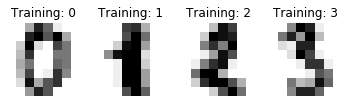

In [23]:
# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(1,4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[:4], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

In [24]:
###  data binarize
threshold = 7
mnist_array = binarize(X_train, threshold=threshold)
mnist_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
y_train

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7,
       7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6,
       6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 4,
       6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5,
       4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3,
       5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6,
       4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 3, 1, 3,
       9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5, 4, 4, 7, 2,
       8, 2, 2, 5, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
       0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7,

In [26]:
# one hot
mnist_label_onehot = OneHotEncoder(categories='auto').fit_transform(y_train.reshape(-1,1)).toarray()
mnist_label_onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
# write to csv
np.savetxt("mnist_8x8_image.csv", X=mnist_array, delimiter=",")
np.savetxt("mnist_8x8_label_onehot.csv", X=mnist_label_onehot, delimiter=",")
np.savetxt("mnist_8x8_label.csv", X=y_train, delimiter=",")


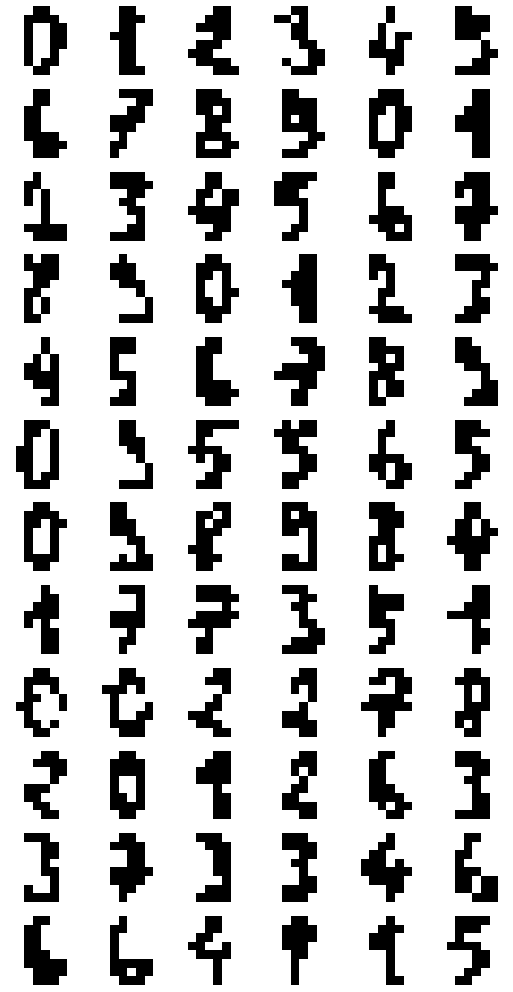

In [28]:
row=12
col = 6

_, axes = plt.subplots(row,col, figsize = (col*1.5,row*1.5))

for i in range(row*col):
    r =int( i / col)
    c = i % col
    ax = axes[r][c]
    image = mnist_array[i]
    ax.set_axis_off()
    ax.imshow(image.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.set_title('Training: %i' % label)

# Python

In [48]:
support(mnist_array, [2], m="ratio")

0.24610244988864144

In [51]:
%time F_list = frequent(mnist_array, minsup=0.3)
print(F_list)

CPU times: user 1min 22s, sys: 381 ms, total: 1min 23s
Wall time: 1min 24s
[array([[ 3],
       [ 4],
       [ 5],
       [10],
       [11],
       [12],
       [13],
       [18],
       [19],
       [20],
       [21],
       [26],
       [27],
       [28],
       [29],
       [34],
       [35],
       [36],
       [37],
       [42],
       [43],
       [44],
       [45],
       [50],
       [51],
       [52],
       [53],
       [59],
       [60],
       [61]]), array([[ 3,  4],
       [ 3, 10],
       [ 3, 11],
       [ 3, 12],
       [ 3, 13],
       [ 3, 18],
       [ 3, 19],
       [ 3, 20],
       [ 3, 21],
       [ 3, 26],
       [ 3, 27],
       [ 3, 28],
       [ 3, 29],
       [ 3, 34],
       [ 3, 35],
       [ 3, 36],
       [ 3, 37],
       [ 3, 42],
       [ 3, 43],
       [ 3, 44],
       [ 3, 45],
       [ 3, 50],
       [ 3, 51],
       [ 3, 52],
       [ 3, 53],
       [ 3, 59],
       [ 3, 60],
       [ 3, 61],
       [ 4,  5],
       [ 4, 10],
       [ 4, 11],
     

In [102]:
%time find_rules(mnist_array, F_list, minconf=0.8)   

CPU times: user 4.53 s, sys: 4.24 ms, total: 4.53 s
Wall time: 4.53 s


[[None],
 [(array([3]), array([4])),
  (array([4]), array([3])),
  (array([3]), array([10])),
  (array([10]), array([3])),
  (array([3]), array([11])),
  (array([11]), array([3])),
  (array([13]), array([3])),
  (array([18]), array([3])),
  (array([28]), array([3])),
  (array([42]), array([3])),
  (array([43]), array([3])),
  (array([50]), array([3])),
  (array([51]), array([3])),
  (array([53]), array([3])),
  (array([3]), array([59])),
  (array([59]), array([3])),
  (array([60]), array([3])),
  (array([5]), array([4])),
  (array([10]), array([4])),
  (array([4]), array([11])),
  (array([11]), array([4])),
  (array([4]), array([12])),
  (array([12]), array([4])),
  (array([13]), array([4])),
  (array([18]), array([4])),
  (array([20]), array([4])),
  (array([21]), array([4])),
  (array([26]), array([4])),
  (array([27]), array([4])),
  (array([28]), array([4])),
  (array([29]), array([4])),
  (array([34]), array([4])),
  (array([35]), array([4])),
  (array([36]), array([4])),
  (array

In [ ]:
getF1(X_train_bin, minsup=0.8)

In [ ]:
F_list

In [58]:
mnist_array.shape

(898, 64)

In [45]:
mnist_array[0:2]

array([[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.]])

In [59]:
df = pd.read_csv("mnist_8x8.csv", sep=",", header=None)

In [60]:
df.shape

(898, 64)